In [60]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
df = pd.read_csv('/content/drive/MyDrive/all_faults.csv')

In [63]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=640
stride=450

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [64]:
X.shape

(6171, 640, 1)

In [65]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)


In [66]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import concatenate

# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')
import tensorflow
tensorflow.config.run_functions_eagerly(True)

no_classes = len(df['fault'].unique())
#head 1
inputs1 = Input(shape=(X.shape[1],X.shape[2]))
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)
# head 2
inputs2 = Input(shape=(X.shape[1],X.shape[2]))
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)
# head 3
inputs3 = Input(shape=(X.shape[1],X.shape[2]))
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)
# merge
merged = concatenate([flat1, flat2, flat3])
# interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

# Plot Model
cnn_model.summary()
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 640, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_16            │ (None, 640, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_17            │ (None, 640, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 441, 64)        │         12,864 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 541, 64)        │          6,464 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 591, 64)        │          3,264 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 441, 64)        │              0 │ conv1d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 541, 64)        │              0 │ conv1d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 591, 64)        │              0 │ conv1d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_15          │ (None, 22, 64)         │              0 │ dropout_15[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_16          │ (None, 54, 64)         │              0 │ dropout_16[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_17          │ (None, 118, 64)        │              0 │ dropout_17[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_15 (Flatten)      │ (None, 1408)           │              0 │ max_pooling1d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_16 (Flatten)      │ (None, 3456)           │              0 │ max_pooling1d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_17 (Flatten)      │ (None, 7552)           │              0 │ max_pooling1d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 12416)          │              0 │ flatten_15[0][0],      │
│ (Concatenate)             │                        │                │ flatten_16[0][0],      │
│                      

 Total params: 1,265,706 (4.83 MB)

 Trainable params: 1,265,706 (4.83 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
batch_size =100
epochs = 5
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 754ms/step - accuracy: 0.3852 - loss: 1.8254 - val_accuracy: 0.8645 - val_loss: 0.7635
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 760ms/step - accuracy: 0.8980 - loss: 0.4011 - val_accuracy: 0.9428 - val_loss: 0.3394
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 775ms/step - accuracy: 0.9390 - loss: 0.2018 - val_accuracy: 0.9671 - val_loss: 0.2315
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 753ms/step - accuracy: 0.9694 - loss: 0.1076 - val_accuracy: 0.9811 - val_loss: 0.1673
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 771ms/step - accuracy: 0.9909 - loss: 0.0434 - val_accuracy: 0.9800 - val_loss: 0.1217


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


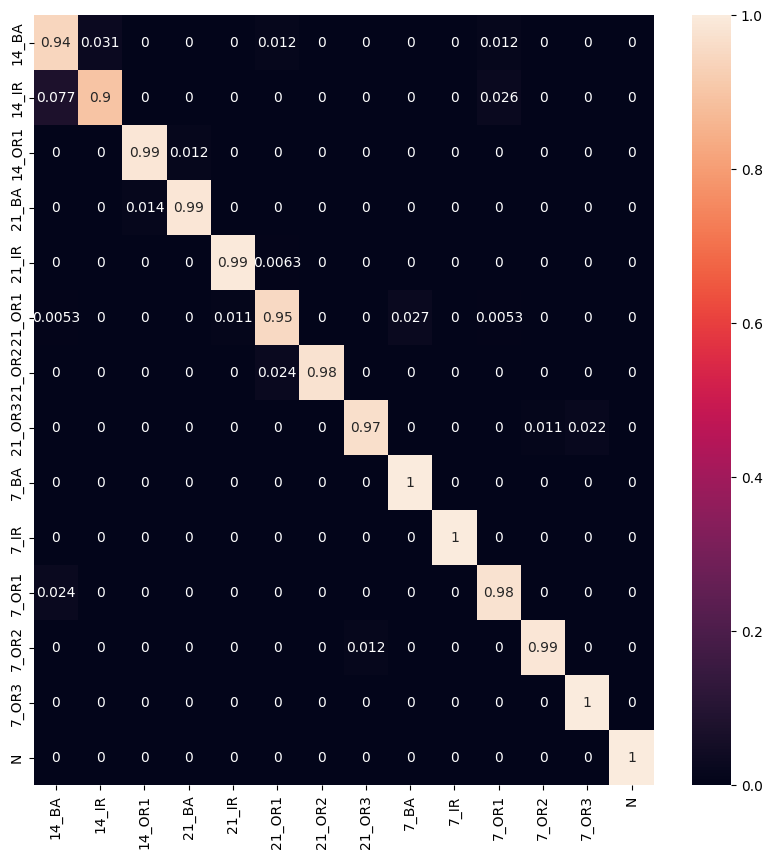

In [68]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [69]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

  1/135 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step


In [70]:
y_viz.shape

(4319, 100)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4319 samples in 0.002s...
[t-SNE] Computed neighbors for 4319 samples in 0.403s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4319
[t-SNE] Computed conditional probabilities for sample 2000 / 4319
[t-SNE] Computed conditional probabilities for sample 3000 / 4319
[t-SNE] Computed conditional probabilities for sample 4000 / 4319
[t-SNE] Computed conditional probabilities for sample 4319 / 4319
[t-SNE] Mean sigma: 1.259822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.953423
[t-SNE] KL divergence after 300 iterations: 1.502449


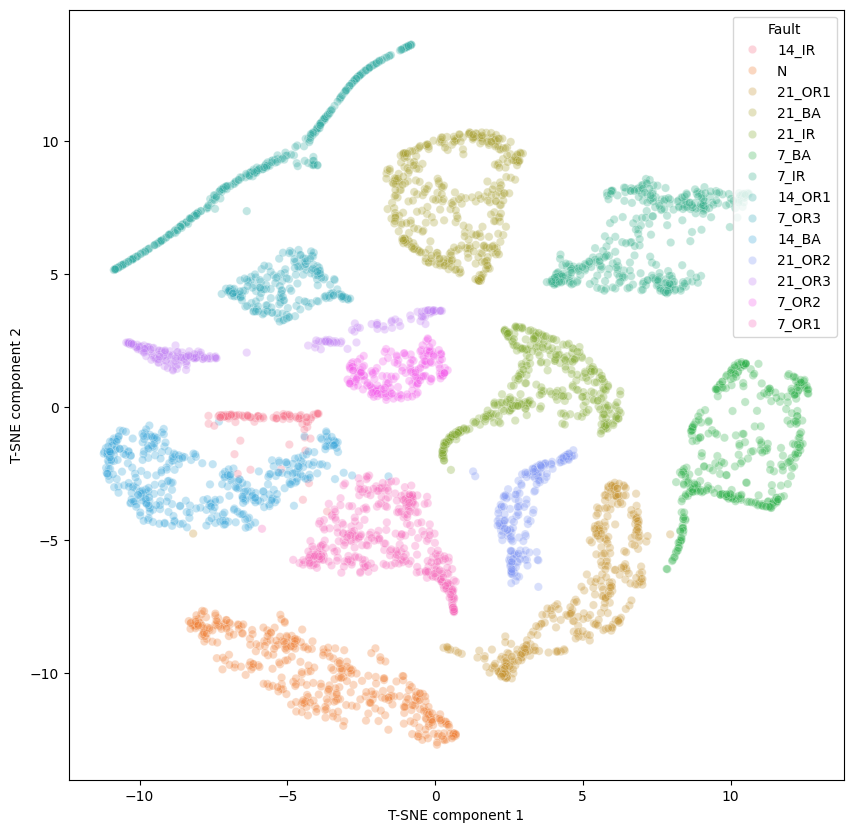

In [71]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()